# Image Features
We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

In [1]:
import random
import numpy as np
from dl4cv.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk. However, we don't apply our previous preprocessing steps, as we want to extract custom features later on.

Train data shape:  (48000, 32, 32, 3)
Train labels shape:  (48000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


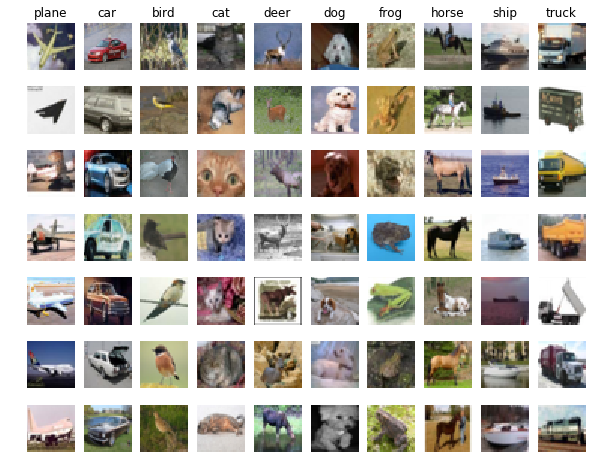

In [2]:
from dl4cv.data_utils import load_CIFAR10
from dl4cv.vis_utils import visualize_cifar10

def get_CIFAR10_data(num_training=48000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for feature extraction and training.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/'
    X, y = load_CIFAR10(cifar10_dir)
    

    # Our training set will be the first num_train points from the original
    # training set.
    mask = range(num_training)
    X_train = X[mask]
    y_train = y[mask]
    
    # Our validation set will be num_validation points from the original
    # training set.
    mask = range(num_training, num_training + num_validation)
    X_val = X[mask]
    y_val = y[mask]
    
    # We use a small subset of the training set as our test set.
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    X_test = X[mask]
    y_test = y[mask]

    return X, y, X_train, y_train, X_val, y_val, X_test, y_test

# Invoke the above function to get our data.
X_raw, y_raw, X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# visualize raw data
visualize_cifar10(X_raw, y_raw)

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from dl4cv.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 48000 images
Done extracting features for 2000 / 48000 images
Done extracting features for 3000 / 48000 images
Done extracting features for 4000 / 48000 images
Done extracting features for 5000 / 48000 images
Done extracting features for 6000 / 48000 images
Done extracting features for 7000 / 48000 images
Done extracting features for 8000 / 48000 images
Done extracting features for 9000 / 48000 images
Done extracting features for 10000 / 48000 images
Done extracting features for 11000 / 48000 images
Done extracting features for 12000 / 48000 images
Done extracting features for 13000 / 48000 images
Done extracting features for 14000 / 48000 images
Done extracting features for 15000 / 48000 images
Done extracting features for 16000 / 48000 images
Done extracting features for 17000 / 48000 images
Done extracting features for 18000 / 48000 images
Done extracting features for 19000 / 48000 images
Done extracting features for 20000 / 48000 images
Done extr

## Train a Softmax classifier on features
Using the multiclass Softmax code developed earlier in the assignment, train a Softmax classifier on top of the features extracted above; this should achieve better results than training the classifier directly on top of raw pixels.

In [7]:
# Use the validation set to tune the learning rate and regularization strength

from dl4cv.classifiers.linear_classifier import Softmax

learning_rates = [1e-7, 2e-7, 4e-7]
regularization_strengths = [1e-4, 500, 2500]
all_classifiers = []
results = {}
best_val = -1
best_softmax = None


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the Softmax; save#
# the best trained classifer in best_softmax. You might also want to play      #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

# perform a grid search to find 'optimal' hyperparameters
for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        # train to get loss and accuracy
        softmax = Softmax()
        print('Train with learning rate {0} and regularization {1}'.format(learning_rate, regularization_strength))
        loss_hist = softmax.train(X_train_feats, y_train, learning_rate=learning_rate, reg=regularization_strength,
                      num_iters=2000, verbose=True)
        y_train_pred = np.mean(y_train == softmax.predict(X_train_feats))
        y_val_pred = np.mean(y_val == softmax.predict(X_val_feats))     
        results[(learning_rate, regularization_strength)] = (y_train_pred, y_val_pred)
        all_classifiers.append((softmax, y_val_pred))
        
        # save if best        
        if y_val_pred > best_val:
            print(':) BEST Validation Accuracy: ', y_val_pred)
            best_val = y_val_pred
            best_softmax = softmax

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
          lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during validation: %f' % best_val)

Train with learning rate 1e-07 and regularization 0.0001
iteration 0 / 2000: loss 2.302347
iteration 100 / 2000: loss 2.303866
iteration 200 / 2000: loss 2.304536
iteration 300 / 2000: loss 2.302378
iteration 400 / 2000: loss 2.303538
iteration 500 / 2000: loss 2.302879
iteration 600 / 2000: loss 2.305024
iteration 700 / 2000: loss 2.302380
iteration 800 / 2000: loss 2.304610
iteration 900 / 2000: loss 2.302301
iteration 1000 / 2000: loss 2.302096
iteration 1100 / 2000: loss 2.303052
iteration 1200 / 2000: loss 2.303267
iteration 1300 / 2000: loss 2.303326
iteration 1400 / 2000: loss 2.302800
iteration 1500 / 2000: loss 2.302996
iteration 1600 / 2000: loss 2.301275
iteration 1700 / 2000: loss 2.302683
iteration 1800 / 2000: loss 2.303211
iteration 1900 / 2000: loss 2.302683
:) BEST Validation Accuracy:  0.107
Train with learning rate 1e-07 and regularization 500
iteration 0 / 2000: loss 3.089448
iteration 100 / 2000: loss 3.080755
iteration 200 / 2000: loss 3.070993
iteration 300 / 200

In [8]:
# Evaluate your trained classifier on the test set
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.146


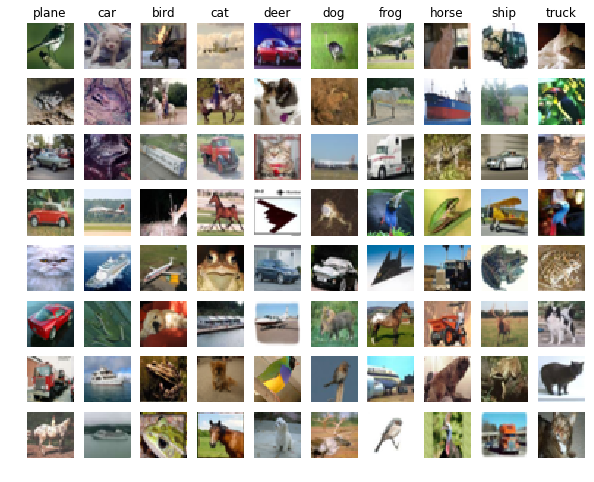

In [9]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    if len(idxs) > 0:
        idxs = np.random.choice(idxs, min(examples_per_class, len(idxs)), replace=False)
    else:
        idxs = []
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Describe the misclassification results that you see. Do they make sense?</p>
</div>

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set.

Note that in the neural net class we have used explicit biases. In the preprocessing of this exercise we have also added a bias dimension to the input, such that we don't have to consider an explicit bias in the linear classifier above. The neural net therefore has an additional parameter in the first layer (the additional bias term), which after all does not matter, as both bias terms can be learned. So just don't get confused by this.

In [48]:
from dl4cv.classifiers.neural_net import TwoLayerNet
import random

input_dim = X_train_feats.shape[1]
num_classes = 10

results = {}
best_val = -1
best_net = None
all_classifiers = []

grid_search_iterations = 50

# define datapoints for the random grid search
hidden_values = (200, 450)
dropout_values = (0.0, 0.7)
learning_values = (1, 9)
learning_values_e = (-2, -0.01)
regularization_values = (1e-5, 0.5)

batch_size_values = (200,250)
num_iterations = 20000


for grid_iteration in range(grid_search_iterations):
    
    # generate random values for hyperparameters
    hidden_size = random.randint(hidden_values[0], hidden_values[1])
    dropout_value = random.uniform(dropout_values[0], dropout_values[1])
    
    learning_rate_1 = random.uniform(learning_values[0], learning_values[1])
    learning_rate_2 = random.uniform(learning_values_e[0], learning_values_e[1])
    learning_rate = learning_rate_1 * (10 ** learning_rate_2) 
    
    regularization = random.uniform(regularization_values[0], regularization_values[1])
    batch_size = random.randint(batch_size_values[0], batch_size_values[1])
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    print('\n\nIteration {0}/{1} -> {2:.2f}%'.format(grid_iteration, grid_search_iterations, (grid_iteration / grid_search_iterations) * 100))
    print('Parameters\n\tLearning rate {0}\n\tRegularization {1}\n\tHidden layer {2}\n\tDropout: {3}\n\tBatch Size: {4}\n'.format(learning_rate, regularization, hidden_size, dropout_value, batch_size))

    # Train the network
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=num_iterations, batch_size=batch_size,
                learning_rate=learning_rate,
                learning_rate_decay=0.95,
                reg=0.000007868, 
                dropout=(dropout_value, True),
                verbose=False)


    # train to get loss and accuracy
    y_train_pred = np.mean(y_train == net.predict(X_train_feats))
    y_val_pred = np.mean(y_val == net.predict(X_val_feats))     
    results[(learning_rate, regularization, hidden_size, dropout_value, batch_size)] = (y_val_pred, y_train_pred)
    all_classifiers.append((net, y_val_pred))

    # save if best        
    if y_val_pred > best_val:
        print('----> :) BEST Validation Accuracy: ', y_val_pred)
        best_val = y_val_pred
        best_net = net

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
#net = TwoLayerNet(input_dim, hidden_dim, num_classes)
# Train the network
#stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
#num_iters=5000, batch_size=256,
#learning_rate=0.9, learning_rate_decay=0.95,
#reg=1e-3, verbose=False)

# Predict on the validation set
#val_acc = (net.predict(X_val_feats) == y_val).mean()
print('Validation accuracy: ', val_acc)

#best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################



Iteration 0/50 -> 0.00%
Parameters
	Learning rate 0.2437038214279248
	Regularization 0.38625148058618414
	Hidden layer 384
	Dropout: 0.6675121132239903
	Batch Size: 211

Epoch	Train Loss	Train accuracy		Test Loss	Test accuracy	Duration
0.0	2.30259		12.80%			2.30244		10.20%		0.008
1.0	2.13635		37.91%			1.70914		37.90%		1.345
2.0	1.55737		55.45%			1.38885		50.70%		1.322
3.0	1.43297		51.66%			1.35104		51.30%		1.355
4.0	1.38538		54.98%			1.31390		52.30%		1.518
5.0	1.36268		57.35%			1.29445		53.50%		1.552
6.0	1.33958		60.66%			1.26195		55.30%		1.366
7.0	1.30842		58.77%			1.25666		54.50%		1.386
8.0	1.30204		60.66%			1.23551		56.30%		1.380
9.0	1.28619		61.61%			1.22691		57.10%		1.326
10.0	1.26804		57.82%			1.21557		57.20%		1.355
11.0	1.25378		64.93%			1.20487		58.00%		1.352
12.0	1.23589		62.56%			1.20517		57.10%		1.331
13.0	1.23353		64.93%			1.19641		57.60%		1.322
14.0	1.22366		63.51%			1.19492		58.30%		1.387
15.0	1.22041		65.40%			1.19036		58.10%		1.352
16.0	1.20885		67.77%			1.18367		57.8

51.0	0.96723		66.67%			1.13560		62.60%		1.539
52.0	0.95970		71.31%			1.13538		62.70%		1.558
53.0	0.97232		67.51%			1.13400		62.20%		1.563
54.0	0.96019		67.93%			1.13289		62.60%		1.532
55.0	0.96116		66.24%			1.13610		62.00%		1.573
56.0	0.96402		68.35%			1.13668		62.00%		1.556
57.0	0.96310		70.46%			1.13753		61.90%		1.568
58.0	0.95433		69.20%			1.13857		62.30%		1.547
59.0	0.94898		70.89%			1.13881		61.90%		1.563
60.0	0.95262		68.35%			1.13671		62.00%		1.583
61.0	0.95245		69.20%			1.13661		62.10%		1.566
62.0	0.95335		68.78%			1.13647		62.40%		1.553
> Early Stopping after 10 epochs of no improvements.
> Restoring params of best model with validation accuracy of:  0.627
----> :) BEST Validation Accuracy:  0.627


Iteration 3/50 -> 6.00%
Parameters
	Learning rate 1.723526921752945
	Regularization 0.4298768693744414
	Hidden layer 352
	Dropout: 0.25913378026256173
	Batch Size: 207

Epoch	Train Loss	Train accuracy		Test Loss	Test accuracy	Duration
0.0	2.30259		12.56%			2.30129		11.10%		0.007
1.

65.0	0.91799		71.24%			1.12586		61.30%		1.587
66.0	0.91526		70.39%			1.12540		60.90%		1.703
67.0	0.91175		72.53%			1.12502		60.90%		1.729
68.0	0.92084		69.10%			1.12568		61.10%		1.613
69.0	0.91783		74.68%			1.12610		61.10%		1.585
> Early Stopping after 10 epochs of no improvements.
> Restoring params of best model with validation accuracy of:  0.614


Iteration 6/50 -> 12.00%
Parameters
	Learning rate 0.5008741201750674
	Regularization 0.48578069252559536
	Hidden layer 377
	Dropout: 0.1460262209352828
	Batch Size: 236

Epoch	Train Loss	Train accuracy		Test Loss	Test accuracy	Duration
0.0	2.30258		14.41%			2.30217		11.10%		0.008
1.0	1.70897		59.75%			1.36498		50.20%		1.524
2.0	1.32690		60.59%			1.27892		53.40%		1.546
3.0	1.22481		76.27%			1.23740		56.00%		1.529
4.0	1.14821		75.00%			1.19930		57.30%		1.523
5.0	1.08631		72.46%			1.18682		57.50%		1.511
6.0	1.02641		78.81%			1.19792		57.70%		1.515
7.0	0.99124		80.93%			1.17469		58.90%		1.523
8.0	0.95871		78.39%			1.19281		59.60%		1.505
9.0	

1.0	1.90790		51.85%			1.42753		48.70%		1.558
2.0	1.40742		58.33%			1.32480		53.00%		1.813
3.0	1.33193		55.56%			1.28277		55.00%		1.442
4.0	1.28221		60.65%			1.26005		54.90%		1.627
5.0	1.23854		65.28%			1.21297		56.60%		1.614
6.0	1.20521		67.13%			1.19433		58.80%		1.430
7.0	1.17852		70.83%			1.17809		58.00%		1.609
8.0	1.14640		75.46%			1.16375		59.50%		1.586
9.0	1.12172		67.13%			1.15881		59.50%		1.397
10.0	1.10318		68.98%			1.15836		59.60%		1.420
11.0	1.08125		74.07%			1.15881		59.50%		1.613
12.0	1.07855		75.46%			1.14910		60.40%		1.610
13.0	1.06064		70.37%			1.15259		59.90%		1.380
14.0	1.04432		71.76%			1.14997		60.20%		1.393
15.0	1.03336		72.22%			1.14131		60.90%		1.405
16.0	1.01770		70.37%			1.13576		61.70%		1.564
17.0	1.00665		76.39%			1.13305		61.40%		1.378
18.0	0.99555		76.39%			1.13290		61.20%		1.401
19.0	0.98960		75.00%			1.13144		61.30%		1.374
20.0	0.97711		73.15%			1.14071		61.60%		1.390
21.0	0.96870		71.30%			1.13712		62.10%		1.378
22.0	0.96825		72.22%			1.13351		61.90%		1.5

8.0	0.74490		95.83%			1.48711		57.30%		1.506
9.0	0.68761		97.50%			1.51131		57.20%		1.510
10.0	0.63521		97.50%			1.55511		59.70%		1.496
11.0	0.58590		97.08%			1.58937		58.20%		1.502
12.0	0.54185		97.50%			1.73635		56.80%		1.504
13.0	0.50119		95.83%			1.71098		59.30%		1.503
14.0	0.47451		98.33%			1.72850		57.70%		1.500
15.0	0.43387		99.17%			1.84135		57.90%		1.496
16.0	0.40210		99.58%			1.89610		58.60%		1.577
17.0	0.37628		98.33%			1.93873		56.40%		1.604
18.0	0.35488		98.75%			1.98941		56.70%		1.660
19.0	0.32981		99.58%			2.02688		56.50%		1.676
20.0	0.31153		99.17%			2.07985		55.40%		1.700
> Early Stopping after 10 epochs of no improvements.
> Restoring params of best model with validation accuracy of:  0.597


Iteration 13/50 -> 26.00%
Parameters
	Learning rate 2.9779242112688395
	Regularization 0.04773375679274119
	Hidden layer 412
	Dropout: 0.22402772027698198
	Batch Size: 209

Epoch	Train Loss	Train accuracy		Test Loss	Test accuracy	Duration
0.0	2.30258		14.83%			2.30306		11.10%		0.

43.0	1.30129		51.11%			1.28952		53.50%		1.408
> Early Stopping after 10 epochs of no improvements.
> Restoring params of best model with validation accuracy of:  0.541


Iteration 16/50 -> 32.00%
Parameters
	Learning rate 0.9393902193053631
	Regularization 0.09048832495994329
	Hidden layer 390
	Dropout: 0.1395032938256757
	Batch Size: 234

Epoch	Train Loss	Train accuracy		Test Loss	Test accuracy	Duration
0.0	2.30258		13.25%			2.30264		8.30%		0.008
1.0	1.57233		64.53%			1.38124		49.40%		1.500
2.0	1.25427		75.21%			1.23002		57.70%		1.485
3.0	1.14529		81.20%			1.28206		54.90%		1.517
4.0	1.07421		81.62%			1.25348		57.70%		1.507
5.0	1.00288		84.62%			1.24196		58.20%		1.521
6.0	0.94112		90.60%			1.22969		60.50%		1.459
7.0	0.88411		88.03%			1.29765		60.10%		1.465
8.0	0.84669		92.74%			1.28598		58.60%		1.464
9.0	0.80288		91.45%			1.31590		58.80%		1.839
10.0	0.76538		91.88%			1.35748		58.10%		1.584
11.0	0.73123		91.88%			1.38319		58.50%		1.611
12.0	0.71097		95.73%			1.40040		58.40%		1.567
13.0	

1.0	1.77484		57.27%			1.38816		50.60%		1.543
2.0	1.34996		63.18%			1.32685		52.80%		1.590
3.0	1.26468		60.45%			1.26426		56.10%		1.532
4.0	1.18523		69.09%			1.21487		57.50%		1.575
5.0	1.12165		67.73%			1.21038		57.10%		1.529
6.0	1.08224		73.18%			1.18519		59.10%		1.576
7.0	1.02951		75.00%			1.17867		59.10%		1.601
8.0	0.98265		81.82%			1.17334		60.70%		1.824
9.0	0.94866		75.00%			1.16517		61.50%		1.901
10.0	0.92417		83.18%			1.16833		62.40%		1.778
11.0	0.89080		78.18%			1.16661		61.00%		1.655
12.0	0.85708		81.36%			1.17685		60.10%		1.595
13.0	0.84027		82.27%			1.18280		60.10%		1.710
14.0	0.80885		84.09%			1.19583		61.00%		1.599
15.0	0.79234		81.82%			1.18548		60.40%		1.602
16.0	0.78006		84.55%			1.18282		61.30%		1.693
17.0	0.75884		83.64%			1.18526		61.70%		1.931
18.0	0.73161		84.09%			1.19391		61.90%		1.695
19.0	0.71844		87.27%			1.20960		61.40%		1.660
20.0	0.71719		90.00%			1.21470		60.30%		1.541
> Early Stopping after 10 epochs of no improvements.
> Restoring params of best model wit

10.0	0.94598		90.60%			1.41731		57.30%		1.736
11.0	0.90619		91.88%			1.47590		56.80%		1.710
12.0	0.88382		90.60%			1.46463		57.00%		1.743
13.0	0.84872		94.44%			1.47073		56.00%		1.619
14.0	0.82928		89.74%			1.50292		57.50%		1.518
15.0	0.78316		95.30%			1.53229		57.40%		1.516
16.0	0.77174		92.31%			1.49431		57.40%		1.597
17.0	0.74508		94.02%			1.52260		58.80%		1.740
18.0	0.72025		91.45%			1.58338		59.60%		1.593
19.0	0.71790		91.88%			1.53752		58.80%		1.581
20.0	0.68876		94.87%			1.55911		58.50%		1.530
21.0	0.66612		93.16%			1.60104		57.60%		1.545
22.0	0.64922		95.73%			1.61049		58.20%		1.535
23.0	0.63920		94.44%			1.62649		57.90%		1.536
24.0	0.62287		93.16%			1.66120		58.80%		1.515
25.0	0.61095		92.74%			1.66667		58.20%		1.512
26.0	0.60637		94.02%			1.65413		57.90%		1.577
27.0	0.58244		93.59%			1.68915		58.60%		1.521
28.0	0.58122		94.44%			1.67611		58.40%		1.570
> Early Stopping after 10 epochs of no improvements.
> Restoring params of best model with validation accuracy of:  0.596


It

1.0	1.76317		50.45%			1.38710		51.40%		1.532
2.0	1.33288		66.52%			1.29445		53.80%		1.371
3.0	1.24001		68.30%			1.24681		56.60%		1.616
4.0	1.17408		66.96%			1.21082		58.20%		1.502
5.0	1.11200		69.64%			1.19139		58.60%		1.397
6.0	1.05821		71.43%			1.19934		57.90%		1.622
7.0	1.02115		70.54%			1.18990		60.40%		1.611
8.0	0.97989		74.11%			1.17870		60.50%		1.516
9.0	0.93957		77.68%			1.20239		60.60%		1.413
10.0	0.90688		80.36%			1.17857		61.20%		1.598
11.0	0.88409		82.59%			1.18573		60.90%		1.577
12.0	0.84945		82.14%			1.20937		60.20%		1.621
13.0	0.83094		83.48%			1.21069		59.60%		1.601
14.0	0.80533		83.48%			1.20781		60.90%		1.623
15.0	0.78612		83.48%			1.22575		61.20%		1.629
16.0	0.76915		88.39%			1.23355		60.10%		1.642
17.0	0.74310		90.18%			1.23731		61.10%		1.769
18.0	0.74482		85.27%			1.24923		60.80%		2.238
19.0	0.71835		88.39%			1.24077		60.90%		1.660
20.0	0.70934		85.27%			1.24156		60.60%		1.661
> Early Stopping after 10 epochs of no improvements.
> Restoring params of best model wit

1.0	2.30255		12.78%			2.30248		9.70%		1.675
2.0	2.30256		11.01%			2.30276		9.70%		1.656
3.0	2.30249		10.57%			2.30277		9.70%		1.652
4.0	2.30247		8.37%			2.30260		9.70%		1.668
5.0	2.30242		7.93%			2.30230		9.70%		1.672
6.0	2.30198		10.13%			2.30184		9.90%		1.622
7.0	2.30122		19.38%			2.30047		16.20%		1.642
8.0	2.29896		17.18%			2.29740		15.70%		1.715
9.0	2.29408		18.94%			2.29037		15.20%		1.719
10.0	2.28361		14.10%			2.27576		16.90%		1.736
11.0	2.26219		20.26%			2.24869		19.90%		1.715
12.0	2.22739		25.11%			2.20920		20.50%		1.722
13.0	2.18536		25.11%			2.16481		20.90%		1.736
14.0	2.14172		18.50%			2.12081		22.10%		1.747
15.0	2.10066		22.91%			2.07652		23.20%		1.707
16.0	2.06460		25.55%			2.03276		23.70%		1.722
17.0	2.02671		26.43%			1.99111		24.30%		1.741
18.0	1.98809		28.19%			1.95389		25.10%		1.719
19.0	1.95681		25.11%			1.92204		26.80%		1.751
20.0	1.92844		30.84%			1.89425		27.50%		1.885
21.0	1.90300		29.07%			1.87043		28.10%		1.902
22.0	1.88491		33.48%			1.85007		28.80%		1.934
23.0	

1.0	1.67763		61.67%			1.34805		53.20%		1.769
2.0	1.32969		67.84%			1.28192		54.00%		1.916
3.0	1.23991		73.13%			1.23898		56.90%		1.782
4.0	1.17593		74.01%			1.17098		59.50%		1.940
5.0	1.13466		76.21%			1.18685		58.70%		1.854
6.0	1.09438		79.30%			1.17058		58.90%		1.827
7.0	1.06381		82.38%			1.15877		59.80%		1.727
8.0	1.03271		82.38%			1.15103		59.60%		1.750
9.0	1.00258		81.94%			1.17272		60.90%		1.701
10.0	0.98809		80.18%			1.16049		59.90%		1.840
11.0	0.96637		83.26%			1.16355		59.90%		1.951
12.0	0.94556		81.06%			1.17442		59.40%		1.926
13.0	0.93050		83.26%			1.16091		60.60%		2.225
14.0	0.91042		82.82%			1.16463		60.40%		2.013
15.0	0.89581		83.26%			1.14865		61.80%		1.865
16.0	0.87653		85.90%			1.16615		60.40%		1.793
17.0	0.86398		85.46%			1.17737		59.90%		1.813
18.0	0.85126		81.06%			1.17961		60.70%		1.726
19.0	0.84915		84.58%			1.18798		61.90%		1.642
20.0	0.83119		86.78%			1.17504		61.50%		1.581
21.0	0.82171		86.34%			1.19041		61.80%		1.592
22.0	0.81142		88.55%			1.18293		62.80%		1.5

45.0	0.88830		72.53%			1.12076		62.20%		1.599
46.0	0.88200		75.54%			1.12221		62.70%		1.538
47.0	0.88353		69.10%			1.11960		62.30%		1.552
48.0	0.88027		73.39%			1.12755		62.50%		1.534
49.0	0.88031		71.67%			1.12660		62.90%		1.529
50.0	0.87469		73.82%			1.12459		62.70%		1.527
51.0	0.87297		72.96%			1.12087		63.10%		1.537
52.0	0.87190		74.68%			1.11968		62.90%		1.535
53.0	0.87338		73.82%			1.12098		62.80%		1.555
54.0	0.87657		71.67%			1.12063		62.90%		1.535
> Early Stopping after 10 epochs of no improvements.
> Restoring params of best model with validation accuracy of:  0.632


Iteration 38/50 -> 76.00%
Parameters
	Learning rate 1.5088806635005962
	Regularization 0.11553309574951114
	Hidden layer 214
	Dropout: 0.4185794113188638
	Batch Size: 216

Epoch	Train Loss	Train accuracy		Test Loss	Test accuracy	Duration
0.0	2.30258		14.81%			2.30172		9.70%		0.008
1.0	1.57486		73.15%			1.32014		54.00%		1.546
2.0	1.34566		75.46%			1.31598		52.70%		1.344
3.0	1.26491		82.41%			1.28783		57.80%		1.337

C:\Users\felix\OneDrive\Studium\Studium\4. Semester\DL4CV\Exercises\01\dl4cv\exercise_1\dl4cv\classifiers\neural_net.py:126: RuntimeWarning: divide by zero encountered in log
  losses = - np.log(scores[range(N), y])


1.0	inf		83.33%			1.89172		45.50%		1.540
2.0	inf		87.08%			1.82040		48.50%		1.569
3.0	1.43686		90.00%			1.75056		49.20%		1.761
4.0	1.35487		87.08%			1.88617		50.30%		1.646
5.0	1.24113		90.00%			1.79680		51.20%		1.599
6.0	1.16862		92.92%			1.83240		51.00%		1.548
7.0	1.08876		92.92%			1.84236		51.60%		1.517
8.0	1.02941		92.92%			1.92223		54.00%		1.498
9.0	0.97565		93.75%			1.92062		54.30%		1.550
10.0	0.91265		96.67%			2.00044		53.40%		1.504
11.0	0.84230		95.42%			2.02103		54.10%		1.524
12.0	0.81470		96.67%			2.06238		55.00%		1.532
13.0	0.74945		95.83%			2.11717		53.20%		1.503
14.0	0.71635		95.83%			2.26690		52.40%		1.518
15.0	0.66406		97.92%			2.19901		54.40%		1.511
16.0	0.62723		97.92%			2.25650		53.90%		1.501
17.0	0.57802		96.67%			2.40664		53.80%		1.499
18.0	0.55275		95.83%			2.35911		53.70%		1.487
19.0	0.53591		97.50%			2.53079		52.30%		1.491
20.0	0.49432		96.67%			2.51879		53.60%		1.516
21.0	0.47311		98.33%			2.64975		52.10%		1.480
22.0	0.45367		98.33%			2.62893		53.50%		1.499
> Ear

38.0	1.27506		54.26%			1.26400		55.60%		1.844
39.0	1.26849		55.16%			1.26051		55.50%		1.827
40.0	1.27096		58.30%			1.25951		55.30%		1.789
41.0	1.28479		55.61%			1.26035		55.60%		1.810
42.0	1.26921		60.09%			1.25872		55.30%		1.737
43.0	1.26253		52.91%			1.25627		55.50%		1.675
44.0	1.26320		53.81%			1.25535		55.60%		1.715
45.0	1.26349		58.74%			1.25527		55.70%		1.796
46.0	1.26566		56.95%			1.25569		55.40%		1.675
47.0	1.25984		56.05%			1.25372		55.30%		1.644
48.0	1.26337		55.16%			1.25323		55.10%		1.675
49.0	1.25368		62.33%			1.25254		55.40%		1.663
50.0	1.24292		56.50%			1.25321		55.60%		1.653
51.0	1.25051		55.61%			1.25177		55.10%		1.644
52.0	1.25751		61.43%			1.25202		55.30%		1.640
53.0	1.25109		57.85%			1.25063		55.50%		1.785
54.0	1.26174		52.47%			1.25067		55.40%		1.657
55.0	1.25364		56.95%			1.24969		55.10%		1.790
> Early Stopping after 10 epochs of no improvements.
> Restoring params of best model with validation accuracy of:  0.557


Iteration 44/50 -> 88.00%
Parameters
	Learning r

28.0	0.99356		75.68%			1.15099		61.40%		1.515
29.0	0.98766		77.03%			1.14401		61.30%		1.509
30.0	0.98275		75.23%			1.14337		61.60%		1.512
31.0	0.99004		77.03%			1.14461		61.90%		1.524
32.0	0.98390		77.03%			1.14187		62.30%		1.555
33.0	0.98849		68.92%			1.13817		61.60%		1.512
34.0	0.97176		78.83%			1.13903		62.60%		1.508
35.0	0.97681		77.48%			1.14268		62.30%		1.552
36.0	0.97674		80.18%			1.14143		62.00%		1.557
37.0	0.96334		76.13%			1.14026		62.20%		1.554
38.0	0.96735		72.07%			1.13859		61.80%		1.555
39.0	0.96392		77.03%			1.14008		62.00%		1.552
40.0	0.95804		77.48%			1.14473		61.30%		1.558
41.0	0.95459		76.13%			1.13959		61.20%		1.557
42.0	0.94535		76.13%			1.14407		61.40%		1.590
43.0	0.94657		75.23%			1.14048		61.80%		1.551
44.0	0.94514		74.32%			1.13989		61.70%		1.553
> Early Stopping after 10 epochs of no improvements.
> Restoring params of best model with validation accuracy of:  0.626


Iteration 47/50 -> 94.00%
Parameters
	Learning rate 0.20642484766751185
	Regularization 0.2915

In [49]:
# sort results
# Print out results.
for (lr, reg, hs, do, bs) in sorted(results, key=results.get):
    val_accuracy, train_accuracy = results[(lr, reg, hs, do, bs)]
    print('lr {0:.5f} reg {1:.9f} hs {2} do {3} bs {4} - train accuracy: {5:.5f} val accuracy: {6:.5f}'.format(
          lr, reg, hs, do, bs, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during validation: %f' % best_val)

lr 0.01460 reg 0.406580315 hs 365 do 0.6264672141522527 bs 227 - train accuracy: 0.41437 val accuracy: 0.41600
lr 0.04847 reg 0.395000229 hs 337 do 0.5066511620231005 bs 245 - train accuracy: 0.54002 val accuracy: 0.53500
lr 0.04706 reg 0.347519814 hs 286 do 0.317742531893911 bs 225 - train accuracy: 0.54508 val accuracy: 0.54100
lr 0.04695 reg 0.356964994 hs 235 do 0.44588555000208174 bs 205 - train accuracy: 0.55183 val accuracy: 0.54200
lr 4.24605 reg 0.325993829 hs 434 do 0.10662735103102064 bs 240 - train accuracy: 0.79529 val accuracy: 0.55000
lr 0.06451 reg 0.233951388 hs 434 do 0.4563753336510261 bs 223 - train accuracy: 0.56865 val accuracy: 0.55700
lr 0.10177 reg 0.294150889 hs 387 do 0.6932946075042057 bs 231 - train accuracy: 0.56669 val accuracy: 0.55900
lr 0.08149 reg 0.107547250 hs 248 do 0.48949482073274303 bs 226 - train accuracy: 0.58037 val accuracy: 0.56500
lr 0.12366 reg 0.482453347 hs 208 do 0.6905741109104715 bs 211 - train accuracy: 0.59175 val accuracy: 0.56800

In [50]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.
net = best_net
test_acc = (net.predict(X_test_feats) == y_test).mean()
print("Test accuracy: ", test_acc)

Test accuracy:  0.639


## Save the model

When you are satisfied with your training, save the model for submission.

In [51]:
from dl4cv.model_savers import save_feature_neural_net
save_feature_neural_net(best_net)

## Scoring function
We will score the model you have just saved based on the classification accuracy on our test dataset. The scoring function should represent the difficulty of obtaining a good test accuracy and should therefore give 0 points for worse results than random guessing, should be linear in a first regime and exponential beyond that. The onset of exponential growth depends on the problem. In that region you get twice as many points for an additional 10% accuracy.

For this problem we specifically use the following scoring function:

$$f(x) = \left\{
	\begin{array}{ll}
		0  & \mbox{if } x \leq 0.1 \\
		100x & \mbox{if } 0.1 < x \leq 0.59 \\
        \left(\frac{59}{\exp(0.59 \ln(2)/0.1)}\right) \exp(x \ln(2)/0.1) & \mbox{if } 0.59 < x \leq 1
	\end{array}
\right.$$

The function can be plotted in the following cell.

Score:  82.86224766854181


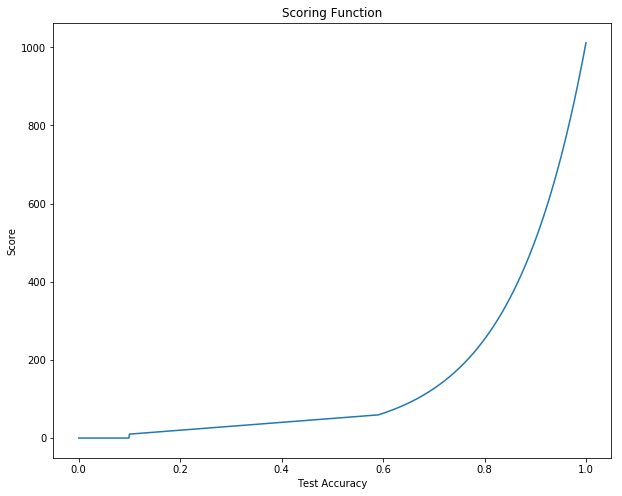

In [52]:
from dl4cv.data_utils import scoring_function
print('Score: ',scoring_function(test_acc, lin_exp_boundary=0.59, doubling_rate=0.1))
x = np.linspace(0, 1, num=1000)
plt.plot(x, scoring_function(x, lin_exp_boundary=0.59, doubling_rate=0.1))
plt.title('Scoring Function')
plt.xlabel('Test Accuracy')
plt.ylabel('Score')
plt.show()